## Environmental Source Apportionment Toolkit (ESAT) Simulator


In [ ]:
# When running from Google Colab or other Jupyter notebook cloud environment, the esat python package may need to be installed.
# If the python package file is available locally run a pip install for the specific wheel for your current OS/Arch
#! pip install esat

#### Code Imports

In [1]:
from esat.data.datahandler import DataHandler
from esat.model.batch_sa import BatchSA
from esat.data.analysis import ModelAnalysis, BatchAnalysis
from esat_eval.simulator import Simulator
from esat.estimator import FactorEstimator

#### Synthetic Dataset

Generate a synthetic dataset where the factor profiles and contributions are pre-determined for model output analysis.

In [2]:
# Synethic dataset parameters
seed = 42
syn_factors = 6                # Number of factors in the synthetic dataset
syn_features = 40              # Number of features in the synthetic dataset
syn_samples = 5000             # Number of samples in the synthetic dataset
outliers = True                # Add outliers to the dataset
outlier_p = 0.10               # Decimal percent of outliers in the dataset
outlier_mag = 1.25                # Magnitude of outliers
contribution_max = 2           # Maximum value of the contribution matrix (W) (Randomly sampled from a uniform distribution)
noise_mean_min = 0.03          # Min value for the mean of noise added to the synthetic dataset, used to randomly determine the mean decimal percentage of the noise for each feature.
noise_mean_max = 0.05          # Max value for the mean of noise added to the synthetic dataset, used to randomly determine the mean decimal percentage of the noise for each feature.
noise_scale = 0.02             # Scale of the noise added to the synthetic dataset
uncertainty_mean_min = 0.04    # Min value for the mean uncertainty of a data feature, used to randomly determine the mean decimal percentage for each feature in the uncertainty dataset. 
uncertainty_mean_max = 0.06    # Max value for the mean uncertainty of a data feature, used to randomly determine the mean decimal percentage for each feature in the uncertainty dataset. 
uncertainty_scale = 0.01       # Scale of the uncertainty matrix

In [3]:
# Initialize the simulator with the above parameters
simulator = Simulator(seed=seed,
                      factors_n=syn_factors,
                      features_n=syn_features,
                      samples_n=syn_samples,
                      outliers=outliers,
                      outlier_p=outlier_p,
                      outlier_mag=outlier_mag,
                      contribution_max=contribution_max,
                      noise_mean_min=noise_mean_min,
                      noise_mean_max=noise_mean_max,
                      noise_scale=noise_scale,
                      uncertainty_mean_min=uncertainty_mean_min,
                      uncertainty_mean_max=uncertainty_mean_max,
                      uncertainty_scale=uncertainty_scale
                     )

29-Jul-25 10:23:43 - Synthetic profiles generated


In [4]:
# Example command for passing in a custom factor profile matrix, instead of the randomly generated profile matrix.
# my_profile = np.ones(shape=(syn_factors, syn_features))
# simulator.generate_profiles(profiles=my_profile)

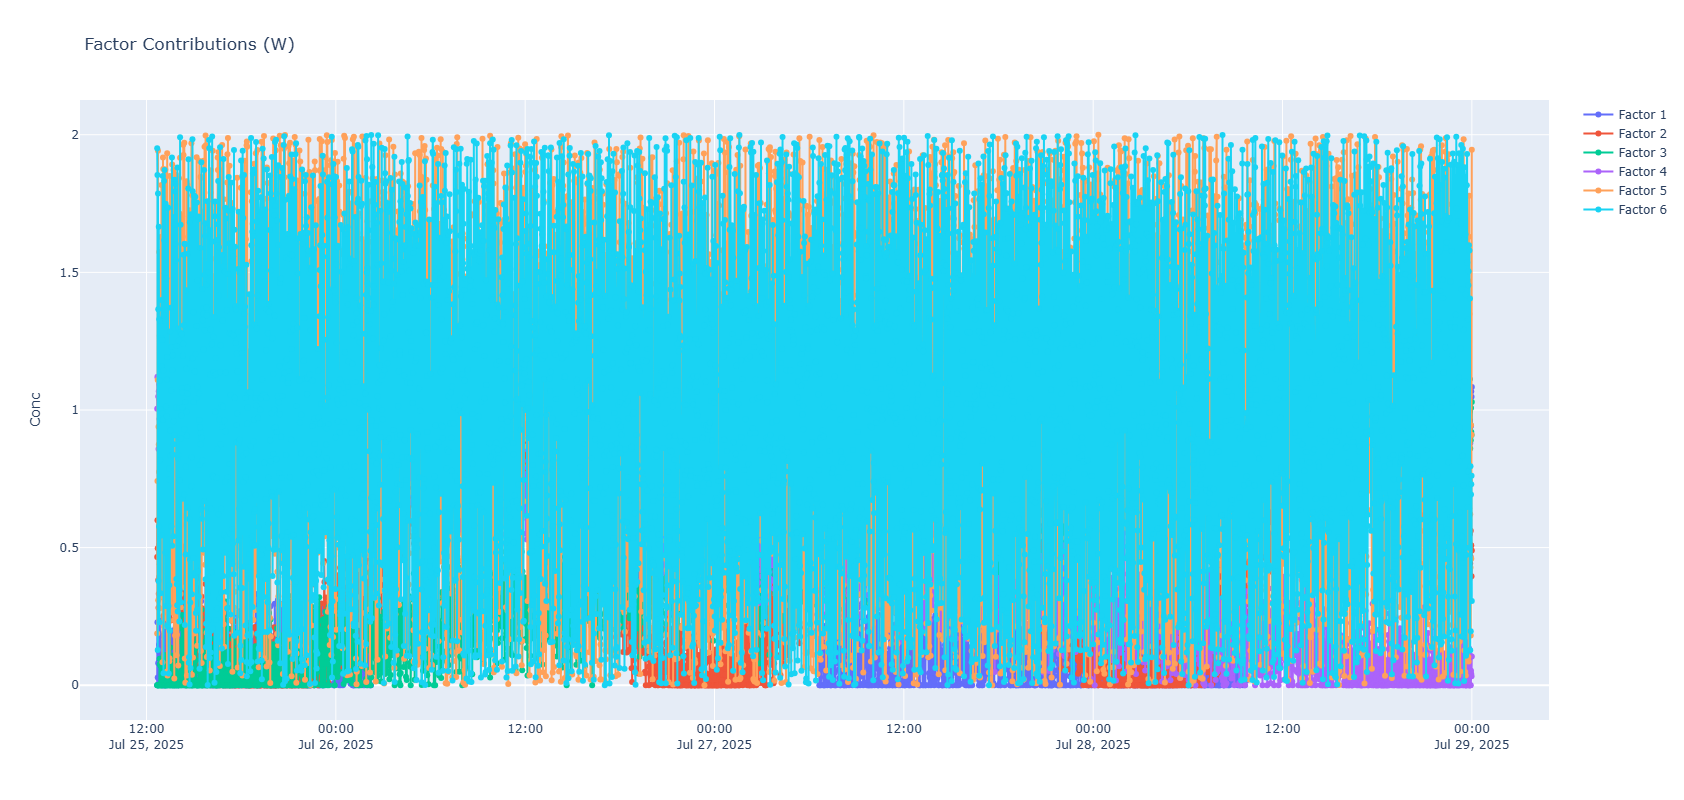

In [8]:
# Example of how to customize the factor contributions. Curve_type options: 'uniform', 'decreasing', 'increasing', 'logistic', 'periodic'
# simulator.update_contribution(factor_i=0, curve_type="logistic", scale=0.1, frequency=0.5)
# simulator.update_contribution(factor_i=1, curve_type="periodic", minimum=0.0, maximum=1.0, frequency=0.5, scale=0.1)
# simulator.update_contribution(factor_i=2, curve_type="increasing", minimum=0.0, maximum=1.0, scale=0.1)
# simulator.update_contribution(factor_i=3, curve_type="decreasing", minimum=0.0, maximum=1.0, scale=0.1)
simulator.plot_synthetic_contributions()

#### Load Data
Assign the processed data and uncertainty datasets to the variables V and U. These steps will be simplified/streamlined in a future version of the code.

In [6]:
syn_input_df, syn_uncertainty_df = simulator.get_data()

29-Jul-25 10:23:43 - Synthetic data generated
29-Jul-25 10:23:43 - Synthetic uncertainty data generated
29-Jul-25 10:23:43 - Synthetic dataframes completed
29-Jul-25 10:23:43 - Synthetic source apportionment instance created.


In [7]:
data_handler = DataHandler.load_dataframe(input_df=syn_input_df, uncertainty_df=syn_uncertainty_df)
data_handler._aggregate_data()
V, U = data_handler.get_data()

#### Input/Uncertainty Data Metrics and Visualizations

In [ ]:
# Show the input data metrics, including signal to noise ratio of the data and uncertainty
data_handler.metrics

In [ ]:
# Concentration / Uncertainty Scatter plot for specific feature, feature/column specified by index
data_handler.plot_data_uncertainty(feature_idx=0, include_menu=False)

In [ ]:
# Species Concentration plot comparing features, features/columns specified by index
data_handler.plot_feature_data(x_idx=0, y_idx=1)

In [ ]:
# Species Timeseries, a single or list of features/columns specified by index
data_handler.plot_feature_timeseries(feature_selection=[0,1,2,3])

#### Factor Estimator

With real datasets, the actual number of factors/sources is typically not known. A best guess and running multiple batchs using different factor counts. To assist this process, a factor search can be done to take a quantitative guess at the optimal number of factors.

The factor search will randomly sample a large number of models with different factors, initilaizations, and test masks. The change in the average mean square error (MSE) for each factor count is used as a metric to indicate a potential optimal factor count.

The process uses cross-validation where some percent of values in the input dataset, default 10%, are masked out of the calculation of the training MSE. The test MSE is calculated for the masked out values, and these are values are used in estimating the factor count.

In [ ]:
# Initialize and run factor estimator
samples = 250
min_factors = 2
max_factors = 12

factor_est = FactorEstimator(V=V, U=U)
results = factor_est.run(samples=samples, min_factors=min_factors, max_factors=max_factors)
results

In [ ]:
# Plot the results of the factor search, when using the Simulator we know the actual number of factors and can add it to the plot.
factor_est.plot(actual_count=syn_factors)
estimated_factors = factor_est.estimated_factor

#### Input Parameters

In [ ]:
index_col = "Date"                  # the index of the input/uncertainty datasets
# factors = syn_factors               # the number of factors
factors = 6
method = "ls-nmf"                   # "ls-nmf", "ws-nmf"
models = 20                         # the number of models to train
init_method = "col_means"           # default is column means "col_means", "kmeans", "cmeans"
init_norm = True                    # if init_method=kmeans or cmeans, normalize the data prior to clustering.
seed = 42                           # random seed for initialization
max_iterations = 20000              # the maximum number of iterations for fitting a model
converge_delta = 0.1                # convergence criteria for the change in loss, Q
converge_n = 25                     # convergence criteria for the number of steps where the loss changes by less than converge_delta
verbose = True                      # adds more verbosity to the algorithm workflow on execution.

#### Train Model

In [ ]:
%%time
# Training multiple models, optional parameters are commented out.
sa_models = BatchSA(V=V, U=U, factors=factors, models=models, method=method, seed=seed, max_iter=max_iterations,
                    init_method=init_method, init_norm=init_norm,
                    converge_delta=converge_delta, converge_n=converge_n, 
                    verbose=True
                   )
_ = sa_models.train()

#### Batch Analysis

These methods allow for plotting and reviewing of the overall results of the collection of models produced by the BatchSA training.

In [ ]:
# Perform batch model analysis
batch_analysis = BatchAnalysis(batch_sa=sa_models, data_handler=data_handler)
# Plot the loss of the models over iterations
batch_analysis.plot_loss()

In [ ]:
# Plot the loss distribution for the batch models
batch_analysis.plot_loss_distribution()

In [ ]:
# Plot the temporal residuals for each model, the loss by sample, for a specified feature
batch_analysis.plot_temporal_residuals()

### Compare to Synthetic Data

Compare the set of batch models to the original synthetic factor data.


In [ ]:
simulator.compare(batch_sa=sa_models)


In [ ]:
simulator.plot_comparison()

In [ ]:
# Get best mapping of the most optimal model (by loss), plot those mapping results
# simulator.plot_comparison(model_i=sa_models.best_model)

In [ ]:
# Save the Simulator instance, saves the instance as a pickle file and saves the synthetic profiles, contributions, data and uncertainty as csv files.
# sim_name = "synthetic"
# sim_output_dir = "D:/git/esat/notebooks/"
# simulator.save(sim_name=sim_name, output_directory=sim_output_dir)

In [ ]:
# Load a previously saved Simulator instance
# simulator_file = "D:/git/esat/notebooks/esat_simulator.pkl"
# simulator_2 = Simulator.load(file_path=simulator_file)
# simulator_2.factor_compare.print_results()

In [ ]:
# Selet the highest correlated model
best_model = simulator.factor_compare.best_model
sa_model = sa_models.results[best_model]
best_model

In [ ]:
# Initialize the Model Analysis module
model_analysis = ModelAnalysis(datahandler=data_handler, model=sa_model, selected_model=best_model)

In [ ]:
# Residual Analysis shows the scaled residual histogram, along with metrics and distribution curves. The abs_threshold parameter specifies the condition for the returned values of the function call as those residuals which exceed the absolute value of that threshold.
abs_threshold = 3.0
threshold_residuals = model_analysis.plot_residual_histogram()

In [ ]:
# The model output statistics for the estimated V, including SE: Standard Error metrics, and 3 normal distribution tests of the residuals (KS Normal is used in PMF5)
model_analysis.calculate_statistics()
model_analysis.statistics

In [ ]:
# Model feature observed vs predicted plot with regression and one-to-one lines. Feature/Column specified by index.
model_analysis.plot_estimated_observed()

In [ ]:
# Model feature timeseries analysis plot showing the observed vs predicted values of the feature, along with the residuals shown below. Feature/column specified by index.
model_analysis.plot_estimated_timeseries()

In [ ]:
# Factor profile plot showing the factor sum of concentrations by feature (blue bars), the percentage of the feature as the red dot, and in the bottom plot the normalized contributions by date (values are resampled at a daily timestep for timeseries consistency).
# Factor specified by index.
model_analysis.plot_factor_profile(factor_idx=1)

In [ ]:
# Model factor fingerprint specifies the feature percentage of each factor.
model_analysis.plot_factor_fingerprints(grouped=False)

In [ ]:
# Factor G-Space plot shows the normalized contributions of one factor vs another factor. Factor specified by index.
model_analysis.plot_g_space(factor_1=2, factor_2=1)

In [ ]:
# Factor contribution pie chart shows the percentage of factor contributions for the specified feature, and the corresponding normalized contribution of each factor for that feature (bottom plot). Feature specified by index.
model_analysis.plot_factor_contributions(feature_idx=1)